In [1]:
%matplotlib inline 

# Caching Rest Data Investigation
***

## Table of Contents
***
* [Aim](#aim)
* [Code Setup](#code-setup)
* [Ehcache Data](#ehcache)
* [Hazelcast Data](#hazelcast)
* [Memcached Data](#memcached)
* [Redis Data](#redis)
* [Cache Size Comparison](#cache_size_comparison)
* [Eviction Policy Comparison](#eviction_policy_comparison)

## Aim <a class="anchor" id="aim"></a>
***

The aim of this notebook is to do some Exploratory data analysis on the data obtained from the Caching Rest Application

## Code Setup <a class="anchor" id="code-setup"></a>
***

### Import Libraries

In [46]:
import pymysql
import pandas as pd
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")
plt.rcParams['figure.figsize'] = 14, 8
IMAGE_POOL_SIZE_MB = 2048

### Custom Classes

In [3]:
class CachePerformanceMetric:
    def __init__(self, cache_hit_size, cache_miss_size):
        self.cache_hit_size = cache_hit_size
        self.cache_miss_size = cache_miss_size
        self.total_size = cache_hit_size + cache_miss_size
        self.hit_ratio = cache_hit_size/self.total_size
    
    def __repr__(self):
        return "Hit Ratio : " + str(self.hit_ratio)

class MainCacheAnalyseData:
    def __init__(self, batch_ids, cache_performance_metrics, cache_initial_content_per_batch,
                cache_performance_per_batch, cache_remainder_per_batch, agg_df):
        self.batch_ids = batch_ids
        self.cache_performance_metrics = cache_performance_metrics
        self.cache_initial_content_per_batch = cache_initial_content_per_batch
        self.cache_performance_per_batch = cache_performance_per_batch
        self.cache_remainder_per_batch = cache_remainder_per_batch
        self.agg_df = agg_df
    def __iter__(self):
        yield 'batch_ids', self.batch_ids
        yield 'cache_performance_metrics', self.cache_performance_metrics
        yield 'cache_initial_content_per_batch', self.cache_initial_content_per_batch
        yield 'cache_performance_per_batch', self.cache_performance_per_batch
        yield 'cache_remainder_per_batch', self.cache_remainder_per_batch
        yield 'agg_df', self.agg_df

### Constants

In [4]:
db_connection = pymysql.connect("pidb","dbuser","password","cachetest" )

### Useful Functions

#### Table Read

In [5]:
def read_full_db_table(table_name):
    return pd.read_sql('SELECT * FROM ' + table_name, con=db_connection)

#### Query to Dataframe

In [6]:
def obtain_df_from_query(query_string):
    return pd.read_sql(query_string, con=db_connection)

#### Cache Hit Bytes to Boolean

In [7]:
def convert_cache_hit_to_boolean(df):
    df.cache_hit = df.cache_hit.map({b'\x00' : False, b'\x01' : True})
    return df

#### DF ids to comma seperated string

In [8]:
def df_ids_to_string(df):
    id_list = df.id.tolist()
    id_list = [str(i) for i in id_list]
    return ','.join(id_list)

#### Compute Average Hit Ratio

In [9]:
def compute_average_hit_ratio(agg_df):
    average_hit_ratio = 0
    hit_ratio_list = agg_df.hit_ratio.tolist()
    for hit_ratio in hit_ratio_list:
        average_hit_ratio = average_hit_ratio + hit_ratio
    average_hit_ratio = average_hit_ratio/(len(hit_ratio_list))
    return average_hit_ratio

#### Compute Cache Size from Dataframe

In [10]:
def cache_size_mb_from_cache_content(df):
    return (df[["file_sizekb"]].sum().values[0])/1024

#### DF to Latex Table

In [11]:
# I know there is a to_latex method but it wasn't outputting how I wanted it
def write_df_to_latex_table(df, file_name, table_caption):
    table_label = table_caption.replace(" ", "_")
    with open(output_dir + file_name, "w") as f:
        f.write("\\begin{table}[h!]\n")
        f.write("\\begin{center}\n")
        #f.write("\\resizebox{\\textwidth}{!}{\n")
        f.write("\\begin{tabular}{|" + "".join(["c"] * len(df.columns)) + "|}\n")
        f.write("\\hline \n")
        f.write(" & ".join([str(x).replace("_", " ") for x in df.columns.values]) + " \\\\ [0.5ex] \n")
        f.write("\\hline \\hline \n")
        for i, row in df.iterrows():
            f.write(" & ".join([str(x).replace("_", " ") for x in row.values]) + " \\\\\n")
            f.write("\\hline \n")
        f.write("\\end{tabular} \n")
        #f.write("} \n")
        f.write("\\caption{" + table_caption + "} \n")
        f.write("\\label{table:" + table_label + "} \n")
        f.write("\\end{center} \n")
        f.write("\\end{table}")

#### Process a Set of Parameters

In [12]:
def crunch_the_data(cache_type, cache_size_mb, eviction_policy):
    query_for_batch = ("cache_type == '" + cache_type + "' and cache_size_mb == '" + str(cache_size_mb) 
                       + "' and eviction_policy == '" + eviction_policy + "'")
    # Batches fitting criteria
    batches_df = batch_df.query(query_for_batch)
    
    if(batches_df.empty):
        print("Sorry, No batches for :", cache_type, ",", cache_size_mb, ",",  eviction_policy)
        return None
    
    # Cache Performance
    cp_query = ("SELECT * FROM cache_performance where batch_id in ("
                                              + df_ids_to_string(batches_df)
                                              + ")")
    cache_performace_df = obtain_df_from_query(cp_query)
    # Issue with Booleans coming in as bytes and not booleans
    cache_performace_df = convert_cache_hit_to_boolean(cache_performace_df)
    
    # Cache Initial Content
    cache_initial_content_df = obtain_df_from_query("SELECT * FROM cache_initial_content where batch_id in ("
                                              + df_ids_to_string(batches_df)
                                              + ")")
    # Cache Remainder
    cache_remainder_df = obtain_df_from_query("SELECT * FROM cache_remainder where batch_id in ("
                                              + df_ids_to_string(batches_df)
                                              + ")")

    # Separate data into dictionary based on batches
    cache_performance_per_batch = {}
    cache_initial_content_per_batch = {}
    cache_remainder_per_batch = {}
    batch_ids = batches_df.id.unique().tolist()
    for batch_id in batch_ids :
        query_for_df = "batch_id == " + str(batch_id)
        cache_performance_per_batch[batch_id] = cache_performace_df.query(query_for_df)
        cache_initial_content_per_batch[batch_id] = cache_initial_content_df.query(query_for_df)
        cache_remainder_per_batch[batch_id] = cache_remainder_df.query(query_for_df)
    
    # Compute the Cache Performance Metrics
    cache_performance_metrics = []
    cache_size_mb_initial_list = []
    element_count_at_start_list = []
    element_count_testing_list = []
    number_of_hits_list = []
    number_of_misses_list = []
    hit_ratio_list = []
    cache_size_mb_end_list = []
    element_count_at_end_list = []
    
    for batch_id in batch_ids :
        cp_df = cache_performance_per_batch[batch_id]
        cic_df = cache_initial_content_per_batch[batch_id]
        cr_df = cache_remainder_per_batch[batch_id]
        
        # Cache MB in Cache at Start
        initial_full_cache_size_mb = cache_size_mb_from_cache_content(cic_df)
        element_count_at_start = cic_df.shape[0]
        
        element_count_testing = cp_df.shape[0]
        # Calculate Hit Ratio
        cp_df_hit = cp_df.query("cache_hit")
        cp_df_miss = cp_df.query("cache_hit == False")
        hit_size = cp_df_hit.shape[0]
        miss_size = cp_df_miss.shape[0]
        cache_performance_metric = CachePerformanceMetric(hit_size, miss_size)
        cache_performance_metrics.append(cache_performance_metric)
        
        # Cache MB in Cache at End
        end_full_cache_size_mb = cache_size_mb_from_cache_content(cr_df)
        element_count_at_end = cr_df.shape[0]
        
        # Add Aggregate Data to lists
        cache_size_mb_initial_list.append(initial_full_cache_size_mb)
        element_count_at_start_list.append(element_count_at_start)
        element_count_testing_list.append(element_count_testing)
        number_of_hits_list.append(hit_size)
        number_of_misses_list.append(miss_size)
        hit_ratio_list.append(cache_performance_metric.hit_ratio)
        cache_size_mb_end_list.append(end_full_cache_size_mb)
        element_count_at_end_list.append(element_count_at_end)
   
    # Gen Aggregate Data DF
    agg_data = {"batch_id": batch_ids, 
                "cache_size_mb_start" : cache_size_mb_initial_list,
                "element_count_start" : element_count_at_start_list,
                "element_count_sent" : element_count_testing_list,
                "hits" : number_of_hits_list,
                "misses" : number_of_misses_list,
                "hit_ratio" : hit_ratio_list,
                "cache_size_mb_end" : cache_size_mb_end_list,
                "element_count_end" : element_count_at_end_list
                }
    agg_df = pd.DataFrame(data=agg_data)
     
    # Average Hit Ratio
    average_hit_ratio = compute_average_hit_ratio(agg_df)
    print("Average Hit Ratio :", average_hit_ratio)
    
    # Generate the important data made from this incase it is needed elsewhere
    main_analyse_data = MainCacheAnalyseData(batch_ids, cache_performance_metrics, cache_initial_content_per_batch,
                                            cache_performance_per_batch, cache_remainder_per_batch, agg_df)
    
    # Export the Agg Data
    agg_file_name = cache_type + "_" + str(cache_size_mb) + "MB_" + eviction_policy
    table_caption = cache_type + " " + str(cache_size_mb) + "MB " + eviction_policy
    # Too many columns so need to split
    write_df_to_latex_table(agg_df[["batch_id", 
                                    "cache_size_mb_start", 
                                    "cache_size_mb_end",
                                    "element_count_start",
                                    "element_count_end"]], agg_file_name + "_size.tex", table_caption + " Sizes")

    write_df_to_latex_table(agg_df[["batch_id", 
                                    "element_count_sent", 
                                    "hits",
                                    "misses",
                                    "hit_ratio"]], agg_file_name + "_ratio.tex", table_caption + " Hit Ratio")
    
    # Tried being smart but dictionary was just easiest way to go
    return dict(main_analyse_data)

#### Obtain Batch Info from Id

In [13]:
def obtain_batch_info(batch_id):
    batch_info = batch_df.query("id == " + str(batch_id))
    return batch_info

#### Plot Avg Hit Ratio

In [70]:
def plot_avg_hit_ratio(graph_title, order_descending, *cache_analyse_data):
    if(len(cache_analyse_data) <= 0):
        print("Can't plot what I don't have")
        return
    cache_list = []
    avg_hit_ratio_list = []
    cache_size_mb = 0
    # Going to assume that all batch ids of main data analyse point to same cache type
    for main_cache_analyse_data in  cache_analyse_data:
        batch_info = obtain_batch_info(main_cache_analyse_data["batch_ids"][0])
        avg_hit_ratio = compute_average_hit_ratio(main_cache_analyse_data["agg_df"])
        cache_type = batch_info.cache_type.tolist()[0]
        cache_size_mb = int(batch_info.cache_size_mb.tolist()[0])
        eviction_policy = batch_info.eviction_policy.tolist()[0]
        cache_list.append(cache_type + "-" + str(cache_size_mb) + "MB-" + eviction_policy)
        avg_hit_ratio_list.append(avg_hit_ratio)
    
    d = {"cache": cache_list, "avg_hit_ratio" : avg_hit_ratio_list}
    df = pd.DataFrame(data=d)
    if(order_descending):
        df = df.sort_values(by="avg_hit_ratio", ascending=False)
    fig, ax = plt.subplots()

    expected_hit_ratio = cache_size_mb/IMAGE_POOL_SIZE_MB
    
    df['avg_hit_ratio'].plot.bar()

    ax.set_xticklabels(df["cache"], rotation='vertical')
    ax.axhline(expected_hit_ratio, color="gray")
    ax.text(1.02, expected_hit_ratio, "Expected Ratio : " + str(expected_hit_ratio), va='center', ha="left", bbox=dict(facecolor="w",alpha=0.5),
        transform=ax.get_yaxis_transform())
    
    plt.xlabel('Cache Type')
    plt.ylabel('Avg Hit Ratio')
    plt.title(graph_title)
    plt.show()
    file_name = graph_title.replace(" ", "_") + ".pdf"
    fig.savefig(output_dir + file_name, bbox_inches='tight')

#### Plot Cache Size vs Hit Ratio For a Single Cache Type and Replacement Algorithm

In [15]:
def plot_cache_size_vs_avg_hit_ratio(*cache_analyse_data):
    if(len(cache_analyse_data) <= 0):
        print("Can't plot what I don't have")
        return
    cache_list = []
    eviction_policy_list = []
    cache_size_list = []
    avg_hit_ratio_list = []
    # Going to assume that all batch ids of main data analyse point to same cache type and size
    # Also going to assume that all analyse data fed into this method belong to same cache type and eviction policy
    for main_cache_analyse_data in  cache_analyse_data:
        batch_info = obtain_batch_info(main_cache_analyse_data["batch_ids"][0])
        avg_hit_ratio = compute_average_hit_ratio(main_cache_analyse_data["agg_df"])
        cache_type = batch_info.cache_type.tolist()[0]
        cache_size = batch_info.cache_size_mb.tolist()[0]
        eviction_policy = batch_info.eviction_policy.tolist()[0]
        
        cache_list.append(cache_type)
        eviction_policy_list.append(eviction_policy)
        cache_size_list.append(int(cache_size))
        avg_hit_ratio_list.append(avg_hit_ratio)
        
    
    if(len(set(cache_list)) != 1) or (len(set(eviction_policy_list)) != 1):
        print("The cache type and eviction policy must be constant to use this function only cache size may change")
        return
    
    fig, ax = plt.subplots()
    
    title = "Avg Hit Ratio vs Cache size for " + cache_list[0] + " " + eviction_policy_list[0]
    d = {"cache_size": cache_size_list, "avg_hit_ratio" : avg_hit_ratio_list}
    df = pd.DataFrame(data=d)
    df = df.sort_values(by=["cache_size"], ascending=True)
                                      
    plt.plot(df["cache_size"], df["avg_hit_ratio"], "-o")
    plt.xlabel('Cache Size (MB)')
    plt.ylabel('Avg Hit Ratio')
    plt.title(title)
    plt.show()

#### Plot Cache Size vs Hit Ratio For Multiple Caches

In [16]:
def plot_cache_size_vs_avg_hit_ratio_multiple(*cache_analyse_data_list):
    if(len(cache_analyse_data_list) <= 0):
        print("Can't plot what I don't have")
        return
    
    legend=[]
    file_name = "line_plot"
    fig, ax = plt.subplots()
    for cache_analyse_data in cache_analyse_data_list:
        cache_list = []
        eviction_policy_list = []
        cache_size_list = []
        avg_hit_ratio_list = []
        # Going to assume that all batch ids of main data analyse point to same cache type and size
        # Also going to assume that all analyse data fed into this method belong to same cache type and eviction policy
        for main_cache_analyse_data in  cache_analyse_data:
            batch_info = obtain_batch_info(main_cache_analyse_data["batch_ids"][0])
            avg_hit_ratio = compute_average_hit_ratio(main_cache_analyse_data["agg_df"])
            cache_type = batch_info.cache_type.tolist()[0]
            cache_size = batch_info.cache_size_mb.tolist()[0]
            eviction_policy = batch_info.eviction_policy.tolist()[0]

            cache_list.append(cache_type)
            eviction_policy_list.append(eviction_policy)
            cache_size_list.append(int(cache_size))
            avg_hit_ratio_list.append(avg_hit_ratio)

        if(len(set(cache_list)) != 1) or (len(set(eviction_policy_list)) != 1):
            print("The cache type and eviction policy must be constant to use this function only cache size may change")
            return
        
        file_name = file_name + "_" + cache_list[0] + "_" + eviction_policy_list[0]
        d = {"cache_size": cache_size_list, "avg_hit_ratio" : avg_hit_ratio_list}
        df = pd.DataFrame(data=d)
        df = df.sort_values(by=["cache_size"], ascending=True)

        plt.plot(df["cache_size"], df["avg_hit_ratio"], "-o")
        legend.append(cache_list[0] + " - " + eviction_policy_list[0])
        
    plt.xlabel('Cache Size (MB)')
    plt.ylabel('Avg Hit Ratio')
    plt.title("Avg Hit Ratio vs Cache size")
    lg = plt.legend(legend, frameon=True)
    lg.get_frame().set_facecolor('white')
    plt.show()
    fig.savefig(output_dir + file_name + ".pdf", bbox_inches='tight')

### Global Data

In [17]:
batch_df = obtain_df_from_query("select * from batch where end_date is not null")

In [18]:
output_dir = "output_data/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

## Ehcache Data<a class="anchor" id="ehcache"></a>

### Ehcache LRU 128 MB

In [19]:
ehcache_lru_128_data = crunch_the_data("ehcache", 128, "LRU")
ehcache_lru_128_data["agg_df"]

Average Hit Ratio : 0.061313097309196485


,batch_id,cache_size_mb_end,cache_size_mb_start,element_count_end,element_count_sent,element_count_start,hit_ratio,hits,misses
0,3,127.076172,127.247070,918,4229,769,0.063372,268,3961
1,47,127.022461,127.309570,903,4135,769,0.046433,192,3943
2,48,127.176758,127.283203,911,4203,770,0.060195,253,3950
3,70,127.246094,127.248047,940,4153,771,0.058993,245,3908
4,74,127.182617,126.921875,996,4211,770,0.062930,265,3946
5,110,127.181641,127.277344,947,4222,770,0.063477,268,3954
6,111,126.881836,127.303711,920,4186,770,0.067129,281,3905
7,112,127.285156,127.255859,883,4265,770,0.063775,272,3993
8,113,127.243164,127.274414,935,4163,768,0.063896,266,3897
9,114,127.186523,127.216797,945,4211,770,0.062930,265,3946


### Ehcache LRU 256 MB

In [20]:
ehcache_lru_256_data = crunch_the_data("ehcache", 256, "LRU")
ehcache_lru_256_data["agg_df"]

Average Hit Ratio : 0.12405093823595922


,batch_id,cache_size_mb_end,cache_size_mb_start,element_count_end,element_count_sent,element_count_start,hit_ratio,hits,misses
0,1,254.306641,254.633789,1795,8660,1480,0.125173,1084,7576
1,50,254.305664,254.675781,1857,8744,1483,0.127287,1113,7631
2,54,254.512695,254.792969,1875,8663,1484,0.120628,1045,7618
3,73,254.437500,254.527344,1939,8732,1481,0.124943,1091,7641
4,76,254.435547,254.615234,1799,8689,1484,0.122224,1062,7627


### Ehcache LRU 512 MB

In [21]:
ehcache_lru_512_data = crunch_the_data("ehcache", 512, "LRU")
ehcache_lru_512_data["agg_df"]

Average Hit Ratio : 0.2515564174600436


,batch_id,cache_size_mb_end,cache_size_mb_start,element_count_end,element_count_sent,element_count_start,hit_ratio,hits,misses
0,2,508.772461,509.032227,3777,23756,3525,0.250926,5961,17795
1,52,508.711914,508.941406,3733,23611,3529,0.250265,5909,17702
2,71,508.840820,509.040039,3892,23771,3523,0.250642,5958,17813
3,72,508.854492,509.149414,3769,23777,3529,0.252976,6015,17762
4,75,508.929688,509.119141,3749,23872,3530,0.252974,6039,17833


### Ehcache LFU 512 MB

In [22]:
ehcache_lfu_512_data = crunch_the_data("ehcache", 512, "LFU")
ehcache_lfu_512_data["agg_df"]

Average Hit Ratio : 0.2361690150642211


,batch_id,cache_size_mb_end,cache_size_mb_start,element_count_end,element_count_sent,element_count_start,hit_ratio,hits,misses
0,83,509.000000,509.013672,3547,23456,3521,0.238660,5598,17858
1,84,509.020508,508.725586,3659,23255,3522,0.234960,5464,17791
2,85,509.111328,509.134766,3545,23178,3523,0.230520,5343,17835
3,86,508.908203,508.932617,3632,23408,3520,0.239875,5615,17793
4,87,508.458984,508.840820,3651,23253,3526,0.236830,5507,17746


### Ehcache FIFO 512 MB

In [23]:
ehcache_fifo_512_data = crunch_the_data("ehcache", 512, "FIFO")
ehcache_fifo_512_data["agg_df"]

Average Hit Ratio : 0.2510087991545329


,batch_id,cache_size_mb_end,cache_size_mb_start,element_count_end,element_count_sent,element_count_start,hit_ratio,hits,misses
0,88,508.672852,508.908203,3710,23785,3530,0.251629,5985,17800
1,89,508.960938,509.195312,3815,23758,3520,0.247411,5878,17880
2,90,508.850586,509.115234,3830,23974,3525,0.252440,6052,17922
3,91,508.872070,509.145508,3794,23738,3527,0.250105,5937,17801
4,92,508.831055,509.144531,3805,23858,3528,0.253458,6047,17811


### Ehcache LRU 1024 MB

In [24]:
ehcache_lru_1024_data = crunch_the_data("ehcache", 1024, "LRU")
ehcache_lru_1024_data["agg_df"]

Average Hit Ratio : 0.5003276082717917


,batch_id,cache_size_mb_end,cache_size_mb_start,element_count_end,element_count_sent,element_count_start,hit_ratio,hits,misses
0,4,1017.924805,1017.934570,7578,72474,7245,0.506223,36688,35786
1,46,1018.046875,1018.131836,7445,71246,7252,0.498863,35542,35704
2,49,1017.948242,1018.194336,7500,71413,7248,0.499797,35692,35721
3,51,1017.952148,1018.127930,7490,71620,7248,0.499888,35802,35818
4,53,1017.843750,1018.013672,7550,71013,7249,0.496867,35284,35729


## Hazelcast Data<a class="anchor" id="hazelcast"></a>

### Hazelcast LRU 128 MB

In [25]:
hazelcast_lru_128_data = crunch_the_data("hazelcast", 128, "LRU")
hazelcast_lru_128_data["agg_df"]

Average Hit Ratio : 0.05842392490730425


,batch_id,cache_size_mb_end,cache_size_mb_start,element_count_end,element_count_sent,element_count_start,hit_ratio,hits,misses
0,8,132.353516,127.718750,875,4179,772,0.057191,239,3940
1,61,129.773438,127.718750,892,4180,772,0.062679,262,3918
2,62,127.413086,127.718750,883,4189,772,0.057054,239,3950
3,63,130.021484,127.751953,845,4191,772,0.057266,240,3951
4,64,136.267578,127.600586,881,4212,772,0.057930,244,3968


### Hazelcast LRU 256 MB

In [26]:
hazelcast_lru_256_data = crunch_the_data("hazelcast", 256, "LRU")
hazelcast_lru_256_data["agg_df"]

Average Hit Ratio : 0.1047117446677313


,batch_id,cache_size_mb_end,cache_size_mb_start,element_count_end,element_count_sent,element_count_start,hit_ratio,hits,misses
0,7,262.190430,254.733398,1629,8431,1484,0.100581,848,7583
1,103,258.569336,254.593750,1618,8440,1483,0.104858,885,7555
2,66,256.169922,254.733398,1603,8549,1484,0.107849,922,7627
3,67,256.070312,254.852539,1643,8573,1483,0.106031,909,7664
4,77,260.781250,254.743164,1613,8490,1483,0.104240,885,7605


### Hazelcast LRU 512 MB

In [27]:
hazelcast_lru_512_data = crunch_the_data("hazelcast", 512, "LRU")
hazelcast_lru_512_data["agg_df"]

Average Hit Ratio : 0.2443262156683808


,batch_id,cache_size_mb_end,cache_size_mb_start,element_count_end,element_count_sent,element_count_start,hit_ratio,hits,misses
0,5,515.367188,509.485352,3736,23666,3529,0.247655,5861,17805
1,56,510.565430,509.463867,3746,23635,3529,0.243918,5765,17870
2,57,512.273438,510.043945,3693,23449,3529,0.239754,5622,17827
3,68,516.953125,510.227539,3750,23681,3529,0.243360,5763,17918
4,69,514.762695,509.160156,3710,23726,3530,0.246944,5859,17867


### Hazelcast LFU 512 MB

In [28]:
hazelcast_lfu_512_data = crunch_the_data("hazelcast", 512, "LFU")
hazelcast_lfu_512_data["agg_df"]

Average Hit Ratio : 0.24202690666771062


,batch_id,cache_size_mb_end,cache_size_mb_start,element_count_end,element_count_sent,element_count_start,hit_ratio,hits,misses
0,78,515.871094,509.937500,3657,23551,3529,0.239183,5633,17918
1,79,517.751953,509.267578,3655,23632,3529,0.242214,5724,17908
2,80,519.900391,509.965820,3718,23519,3529,0.240912,5666,17853
3,81,522.021484,509.495117,3642,23558,3529,0.244036,5749,17809
4,82,514.049805,509.160156,3609,23631,3529,0.243790,5761,17870


### Hazelcast LRU 1024 MB

In [29]:
hazelcast_lru_1024_data = crunch_the_data("hazelcast", 1024, "LRU")
hazelcast_lru_1024_data["agg_df"]

Average Hit Ratio : 0.501709512720643


,batch_id,cache_size_mb_end,cache_size_mb_start,element_count_end,element_count_sent,element_count_start,hit_ratio,hits,misses
0,6,1031.755859,1018.132812,7517,71071,7244,0.497967,35391,35680
1,55,1026.896484,1018.143555,7644,71445,7248,0.502037,35868,35577
2,58,1027.230469,1018.183594,7581,71560,7245,0.502278,35943,35617
3,60,1026.925781,1018.047852,7541,71288,7246,0.500238,35661,35627
4,65,1022.010742,1017.898438,7697,72247,7248,0.506028,36559,35688


## Memcached Data<a class="anchor" id="memcached"></a>

### Memcached LRU 128 MB

In [30]:
memcached_lru_128_data = crunch_the_data("memcached", 128, "LRU")
memcached_lru_128_data["agg_df"]

Average Hit Ratio : 0.06037569969959231


,batch_id,cache_size_mb_end,cache_size_mb_start,element_count_end,element_count_sent,element_count_start,hit_ratio,hits,misses
0,13,112.394531,110.031250,973,4167,692,0.057355,239,3928
1,37,112.431641,110.031250,956,4182,692,0.058584,245,3937
2,44,112.133789,110.031250,961,4226,692,0.059394,251,3975
3,96,112.715820,110.031250,970,4216,692,0.062619,264,3952
4,97,113.516602,113.624023,1049,4208,970,0.063926,269,3939


### Memcached LRU 256 MB

In [31]:
memcached_lru_256_data = crunch_the_data("memcached", 256, "LRU")
memcached_lru_256_data["agg_df"]

Average Hit Ratio : 0.10662895989354466


,batch_id,cache_size_mb_end,cache_size_mb_start,element_count_end,element_count_sent,element_count_start,hit_ratio,hits,misses
0,12,230.811523,224.958984,1702,8499,1368,0.104718,890,7609
1,39,229.001953,224.958984,1716,8558,1368,0.104931,898,7660
2,42,229.133789,224.958984,1700,8595,1368,0.109366,940,7655
3,93,230.411133,224.958984,1702,8479,1368,0.104258,884,7595
4,95,230.919922,224.958984,1692,8519,1368,0.109872,936,7583


### Memcached LRU 512 MB

In [32]:
memcached_lru_512_data = crunch_the_data("memcached", 512, "LRU")
memcached_lru_512_data["agg_df"]

Average Hit Ratio : 0.23655077156699228


,batch_id,cache_size_mb_end,cache_size_mb_start,element_count_end,element_count_sent,element_count_start,hit_ratio,hits,misses
0,10,460.295898,454.220703,3589,23089,3274,0.235523,5438,17651
1,36,458.681641,454.220703,3593,23404,3274,0.239745,5611,17793
2,41,458.097656,454.220703,3598,23387,3274,0.238509,5578,17809
3,45,459.563477,454.220703,3600,23278,3274,0.232666,5416,17862
4,94,459.798828,454.220703,3604,23266,3274,0.236310,5498,17768


### Memcached LRU 1024 MB

In [33]:
memcached_lru_1024_data = crunch_the_data("memcached", 1024, "LRU")
memcached_lru_1024_data["agg_df"]

Average Hit Ratio : 0.44720286094468353


,batch_id,cache_size_mb_end,cache_size_mb_start,element_count_end,element_count_sent,element_count_start,hit_ratio,hits,misses
0,11,922.816406,921.205078,6740,64723,6593,0.447600,28970,35753
1,35,923.733398,921.205078,6740,64518,6593,0.449084,28974,35544
2,38,922.737305,921.205078,6739,64047,6593,0.442128,28317,35730
3,40,923.976562,921.205078,6739,65434,6593,0.450194,29458,35976
4,43,922.592773,921.205078,6739,64623,6593,0.447008,28887,35736


## Redis Data<a class="anchor" id="redis"></a>

### Redis LRU 128 MB

In [34]:
redis_lru_128_data = crunch_the_data("redis", 128, "LRU")
redis_lru_128_data["agg_df"]

Average Hit Ratio : 0.05342096440107451


,batch_id,cache_size_mb_end,cache_size_mb_start,element_count_end,element_count_sent,element_count_start,hit_ratio,hits,misses
0,14,114.624023,114.500977,875,4134,699,0.051282,212,3922
1,19,115.110352,113.568359,883,4170,700,0.059712,249,3921
2,20,115.380859,114.900391,869,4173,714,0.051042,213,3960
3,27,114.810547,114.640625,866,4144,709,0.055261,229,3915
4,30,115.322266,114.819336,836,4156,705,0.049808,207,3949


### Redis LRU 256 MB

In [35]:
redis_lru_256_data = crunch_the_data("redis", 256, "LRU")
redis_lru_256_data["agg_df"]

Average Hit Ratio : 0.10991918027222429


,batch_id,cache_size_mb_end,cache_size_mb_start,element_count_end,element_count_sent,element_count_start,hit_ratio,hits,misses
0,17,230.288086,231.068359,1679,8570,1340,0.110035,943,7627
1,26,230.478516,230.618164,1672,8648,1324,0.114940,994,7654
2,29,229.915039,231.077148,1684,8569,1348,0.112032,960,7609
3,33,230.184570,230.653320,1698,8643,1341,0.109684,948,7695
4,99,229.739258,230.608398,1756,8571,1351,0.102905,882,7689


### Redis LRU 512 MB

In [36]:
redis_lru_512_data = crunch_the_data("redis", 512, "LRU")
redis_lru_512_data["agg_df"]

Average Hit Ratio : 0.22731506812679605


,batch_id,cache_size_mb_end,cache_size_mb_start,element_count_end,element_count_sent,element_count_start,hit_ratio,hits,misses
0,16,464.034180,462.880859,3554,23060,3269,0.225369,5197,17863
1,22,461.711914,462.874023,3370,23039,3232,0.227354,5238,17801
2,24,462.573242,461.243164,3474,22952,3241,0.228738,5250,17702
3,31,461.809570,462.390625,3412,22889,3237,0.224081,5129,17760
4,32,462.511719,462.870117,3340,23291,3265,0.231033,5381,17910


### Redis LFU 512 MB

In [37]:
redis_lfu_512_data = crunch_the_data("redis", 512, "LFU")
redis_lfu_512_data["agg_df"]

Average Hit Ratio : 0.22621742401006034


,batch_id,cache_size_mb_end,cache_size_mb_start,element_count_end,element_count_sent,element_count_start,hit_ratio,hits,misses
0,98,463.356445,462.897461,3373,23145,3194,0.226572,5244,17901
1,100,461.819336,463.035156,3425,23183,3223,0.225381,5225,17958
2,101,462.536133,462.693359,3386,23149,3169,0.224113,5188,17961
3,102,463.213867,462.302734,3436,23095,3172,0.227798,5261,17834
4,109,461.894531,462.707031,3456,22973,3209,0.227223,5220,17753


### Redis RANDOM 512 MB

In [38]:
redis_random_512_data = crunch_the_data("redis", 512, "RANDOM")
redis_random_512_data["agg_df"]

Average Hit Ratio : 0.2264029909066212


,batch_id,cache_size_mb_end,cache_size_mb_start,element_count_end,element_count_sent,element_count_start,hit_ratio,hits,misses
0,104,463.041992,462.610352,3355,23281,3202,0.229586,5345,17936
1,105,462.814453,462.088867,3367,23133,3218,0.230839,5340,17793
2,106,464.117188,462.774414,3227,22843,3182,0.221512,5060,17783
3,107,463.061523,462.948242,3511,23156,3170,0.226896,5254,17902
4,108,462.636719,462.573242,3354,22699,3197,0.223182,5066,17633


### Redis LRU 1024 MB

In [39]:
redis_lru_1024_data = crunch_the_data("redis", 1024, "LRU")
redis_lru_1024_data["agg_df"]

Average Hit Ratio : 0.4559020166274956


,batch_id,cache_size_mb_end,cache_size_mb_start,element_count_end,element_count_sent,element_count_start,hit_ratio,hits,misses
0,15,927.371094,927.032227,6841,65308,6715,0.454998,29715,35593
1,21,926.773438,927.357422,6873,65364,6719,0.452757,29594,35770
2,23,927.720703,927.649414,6897,65568,6674,0.455268,29851,35717
3,25,927.010742,926.716797,6903,66153,6727,0.459208,30378,35775
4,28,928.306641,927.422852,6885,65940,6730,0.457279,30153,35787


## Cache Size LRU Comparison<a class="anchor" id="cache_size_comparison"></a>

### 128 MB LRU Comparison

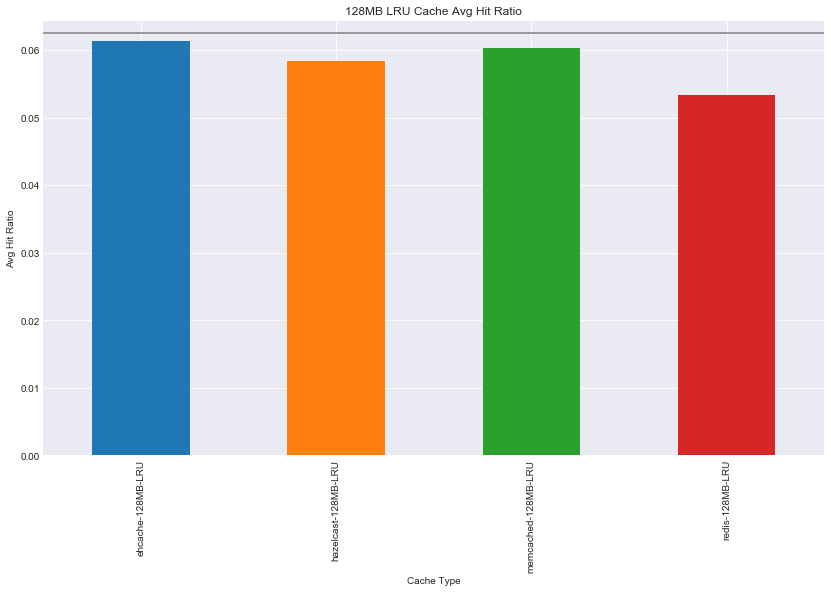

In [65]:
plot_avg_hit_ratio("128MB LRU Cache Avg Hit Ratio",
                    False,
                    ehcache_lru_128_data, 
                    hazelcast_lru_128_data, 
                    memcached_lru_128_data,
                    redis_lru_128_data
                  )

### 256 MB LRU Comparison

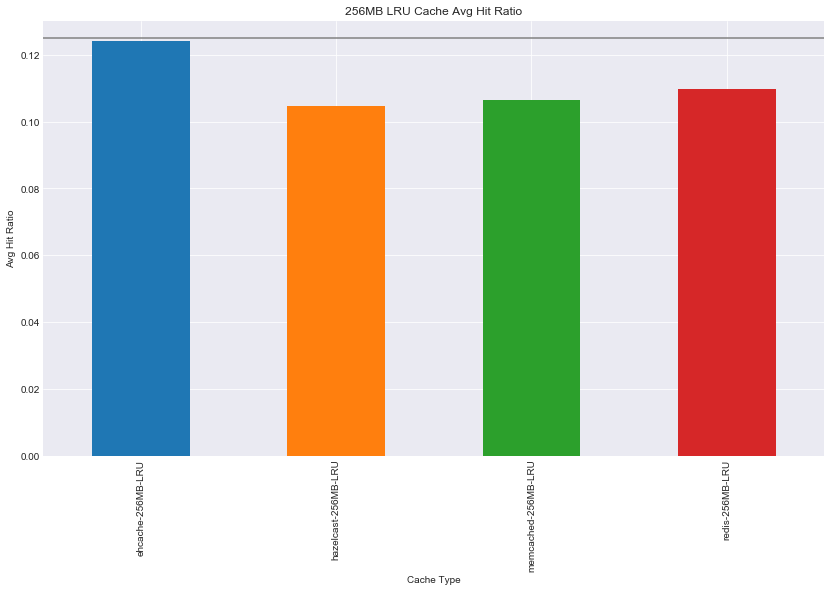

In [64]:
plot_avg_hit_ratio("256MB LRU Cache Avg Hit Ratio", 
                    False,
                    ehcache_lru_256_data, 
                    hazelcast_lru_256_data, 
                    memcached_lru_256_data,
                    redis_lru_256_data
                  )

### 512 MB LRU Comparison

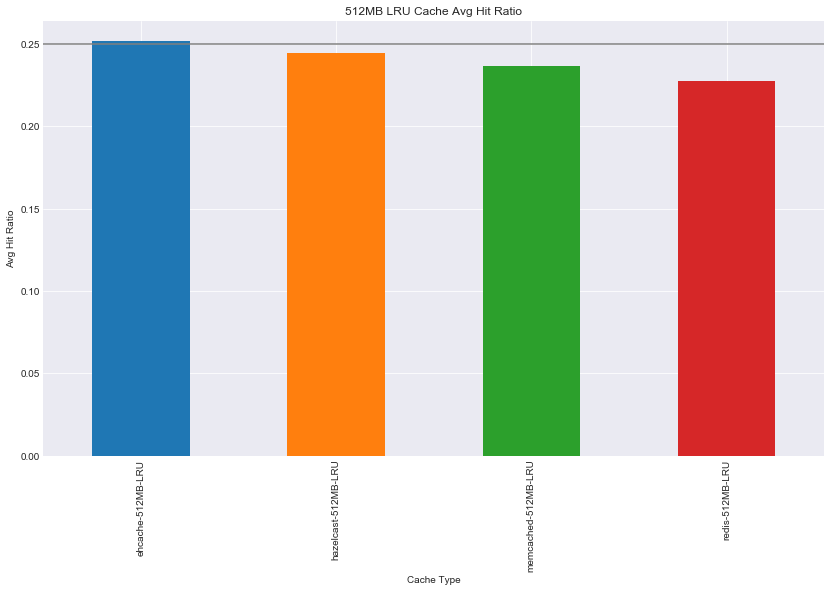

In [63]:
plot_avg_hit_ratio("512MB LRU Cache Avg Hit Ratio",
                    False,
                    ehcache_lru_512_data, 
                    hazelcast_lru_512_data, 
                    memcached_lru_512_data,
                    redis_lru_512_data
                  )

### 1024 MB LRU Comparison

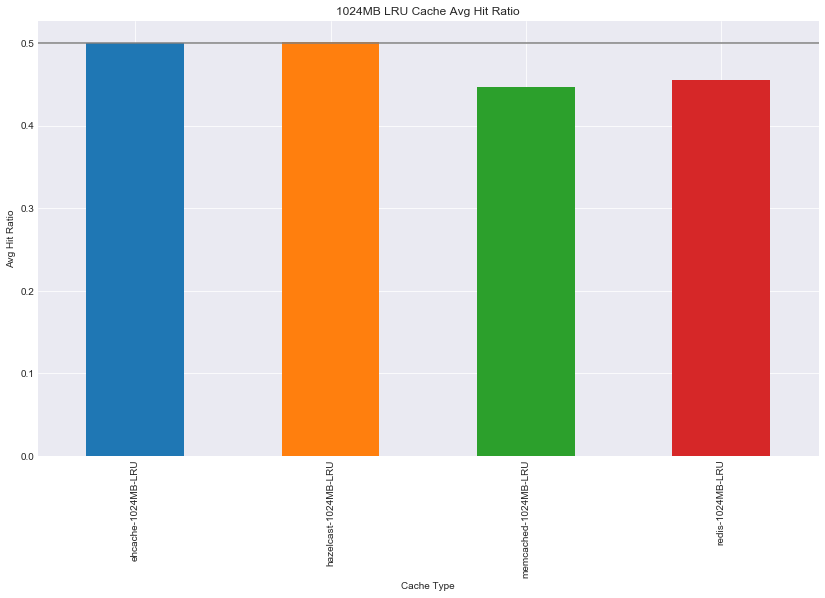

In [62]:
plot_avg_hit_ratio("1024MB LRU Cache Avg Hit Ratio",
                    False,
                    ehcache_lru_1024_data, 
                    hazelcast_lru_1024_data,
                    memcached_lru_1024_data,
                    redis_lru_1024_data
                  )

### Cache Size vs Avg Hit Ratio

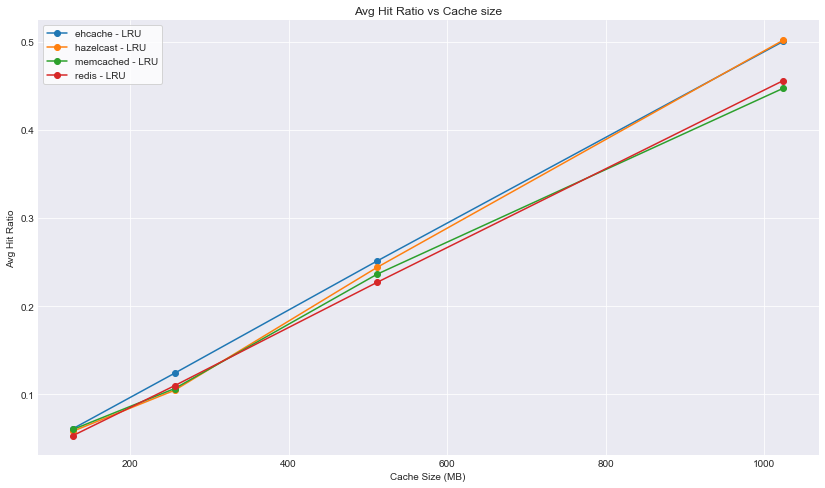

In [44]:
ehcache_list = [ehcache_lru_1024_data,
                   ehcache_lru_512_data,
                   ehcache_lru_256_data,
                   ehcache_lru_128_data
               ]
hazelcast_list = [hazelcast_lru_1024_data,
                   hazelcast_lru_512_data,
                   hazelcast_lru_256_data,
                   hazelcast_lru_128_data
                 ]
memcached_list = [memcached_lru_1024_data,
                   memcached_lru_512_data,
                   memcached_lru_256_data,
                   memcached_lru_128_data
                 ]
redis_list = [redis_lru_1024_data,
              redis_lru_512_data,
              redis_lru_256_data,
              redis_lru_128_data
             ]
plot_cache_size_vs_avg_hit_ratio_multiple(ehcache_list, hazelcast_list, memcached_list, redis_list)

## Eviction Policy Comparison<a class="anchor" id="eviction_policy_comparison"></a>

### 512 MB All Policy Comparison

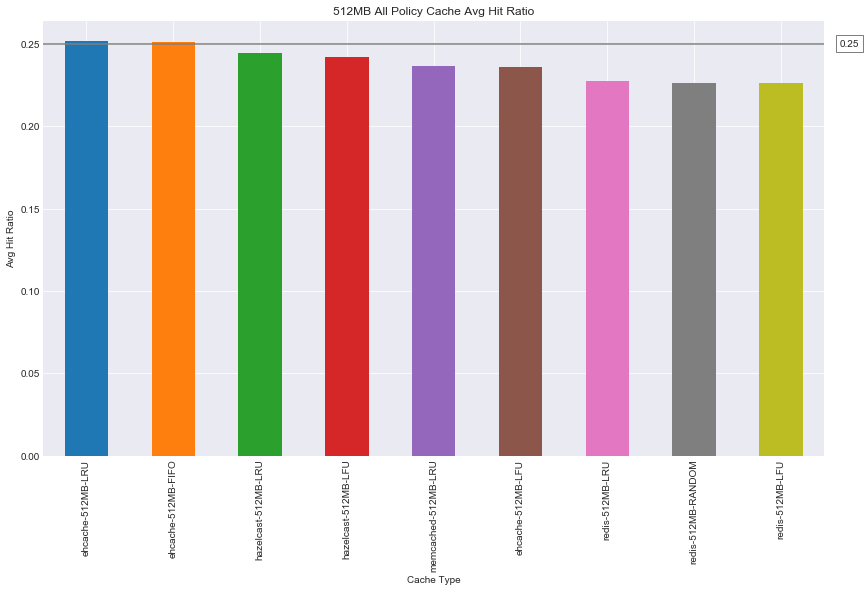

In [71]:
plot_avg_hit_ratio("512MB All Policy Cache Avg Hit Ratio", 
                    True,
                    ehcache_lru_512_data,
                    ehcache_lfu_512_data,
                    ehcache_fifo_512_data,
                    hazelcast_lru_512_data,
                    hazelcast_lfu_512_data,
                    memcached_lru_512_data,
                    redis_lru_512_data,
                    redis_lfu_512_data,
                    redis_random_512_data
                  )